In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
print("done")

done


In [2]:
#Import data
def load_data(data_dir):
    images = []
    for f in os.listdir(data_dir):
        im = cv2.imread(os.path.join(data_dir, f))
        if im is not None:
            images.append(im)
    return images

camera_cal_images_dir= "CarND-Advanced-Lane-Lines-master/camera_cal"
camera_cal_images = load_data(camera_cal_images_dir)
camera_cal_images = np.array(camera_cal_images)
test_images_dir = "CarND-Advanced-Lane-Lines-master/test_images"
test_images = load_data(test_images_dir)
test_images = np.array(test_images)

done


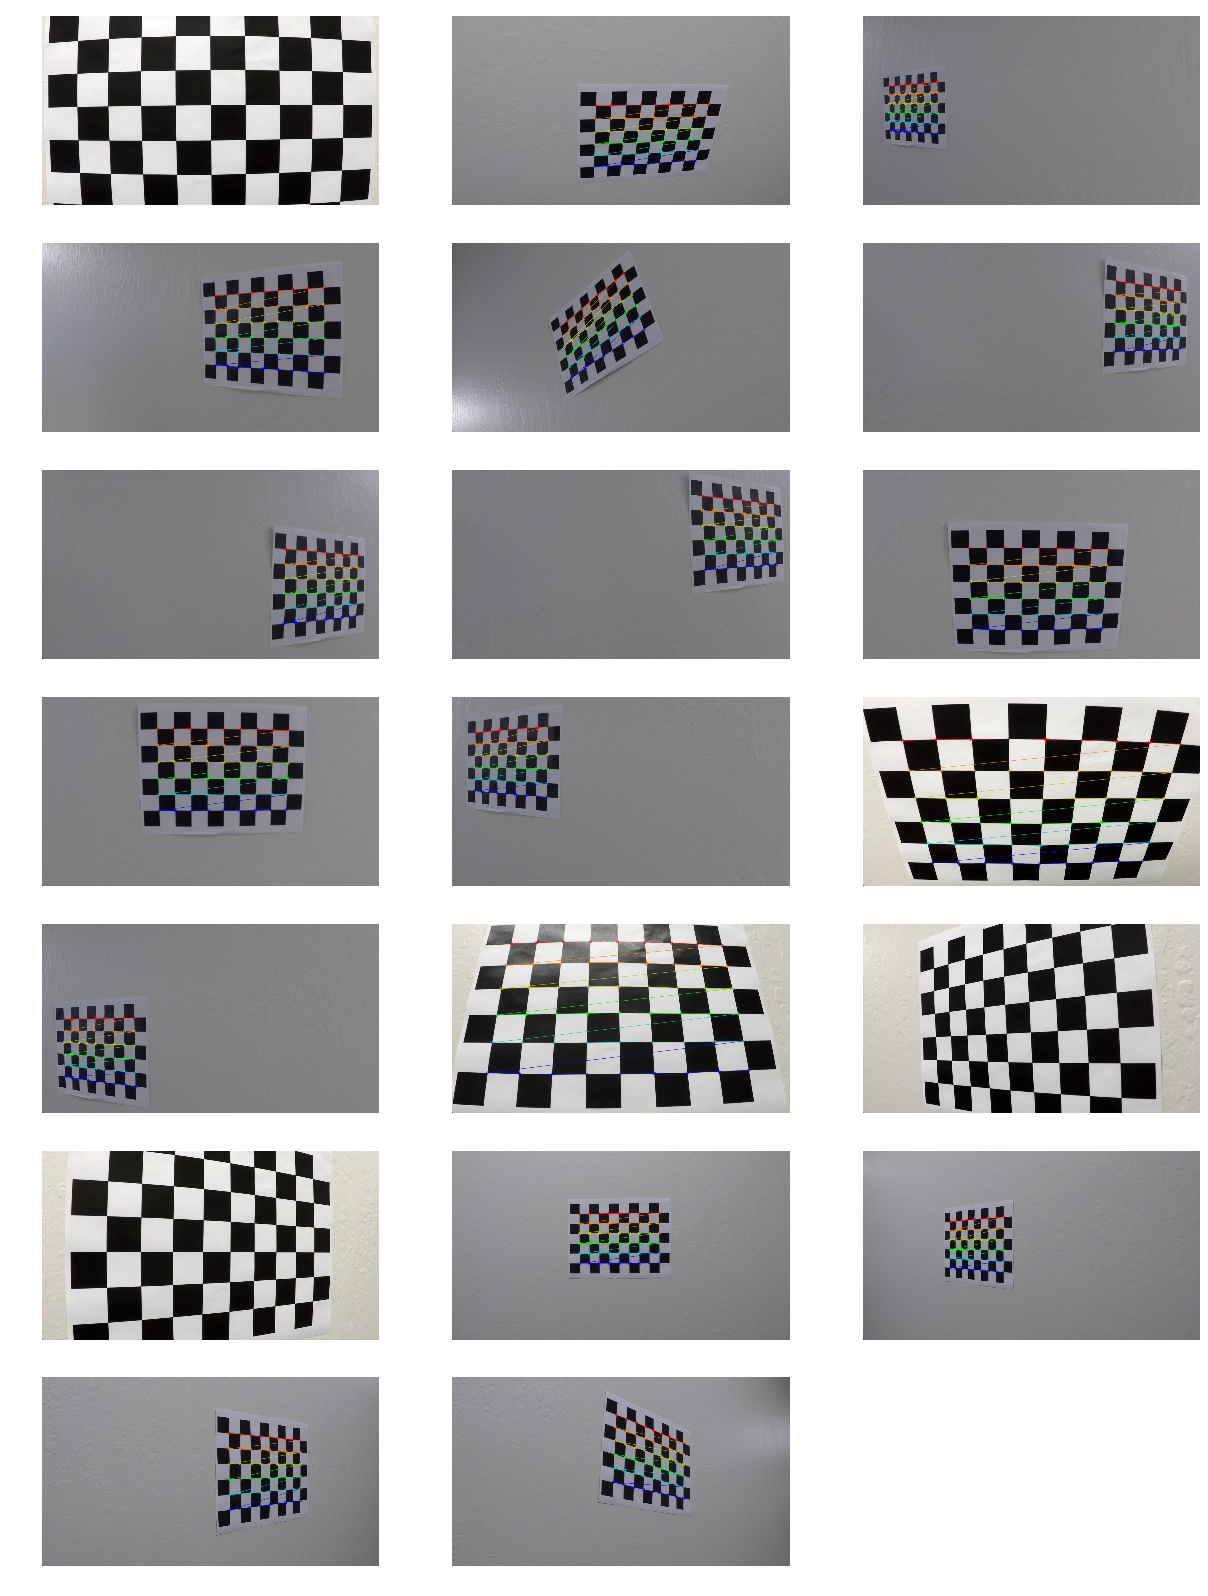

In [4]:
#Calibrate camera
#Create object and image points to be used for calibration
objpoints = []
imgpoints = []
objp = np.zeros((9*6,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

#First print all calibration images to visualize them
fig = plt.figure(figsize=(15,20))
for i in range(len(camera_cal_images)):
    plt.subplot(7,3,1+i)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(camera_cal_images[i], cv2.COLOR_BGR2RGB))
    
#Go through each image and append object and image points to respective arrays
for image in camera_cal_images:
    #turn image to gray scale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    #find chessboard corners using OpenCV
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    #if corners are found, append to imgpoints, add objpoints
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        image = cv2.drawChessboardCorners(image, (9,6), corners, ret)
    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

print('done')

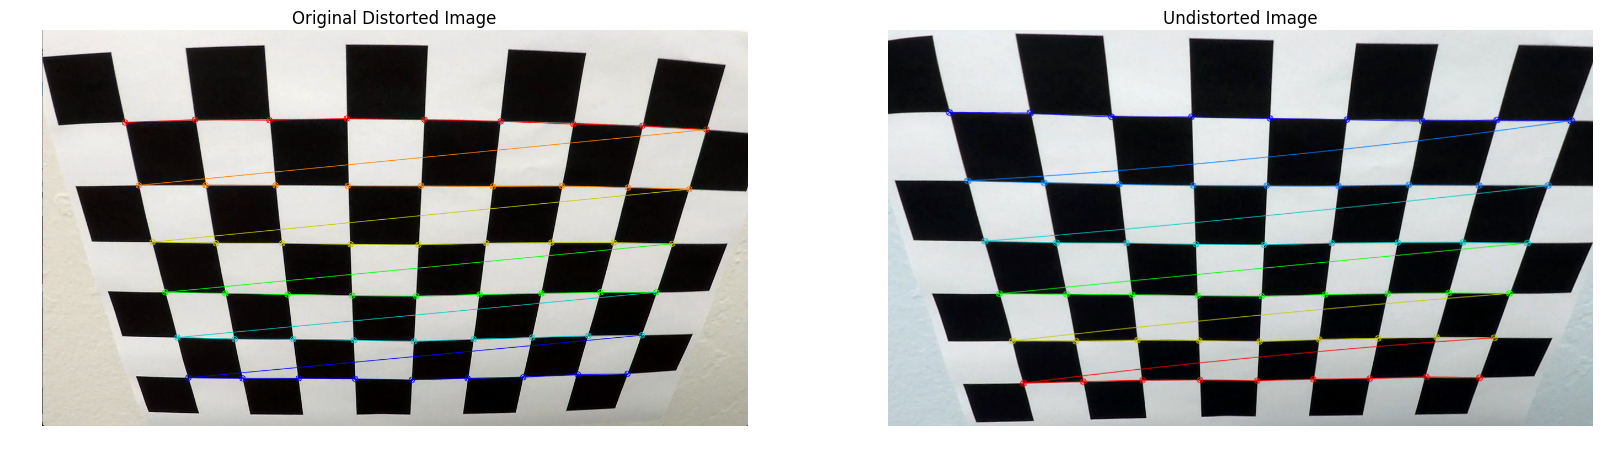

In [5]:
#Apply the distortion correction to the raw image
def dist_correction(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

#Example of undistorted picture
image = camera_cal_images[11]
fig_cal = plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Distorted Image')

image = dist_correction(image)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(image,cmap='gray')
plt.title('Undistorted Image')

In [59]:
def gaussian_blur(img, kernel=5):

    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

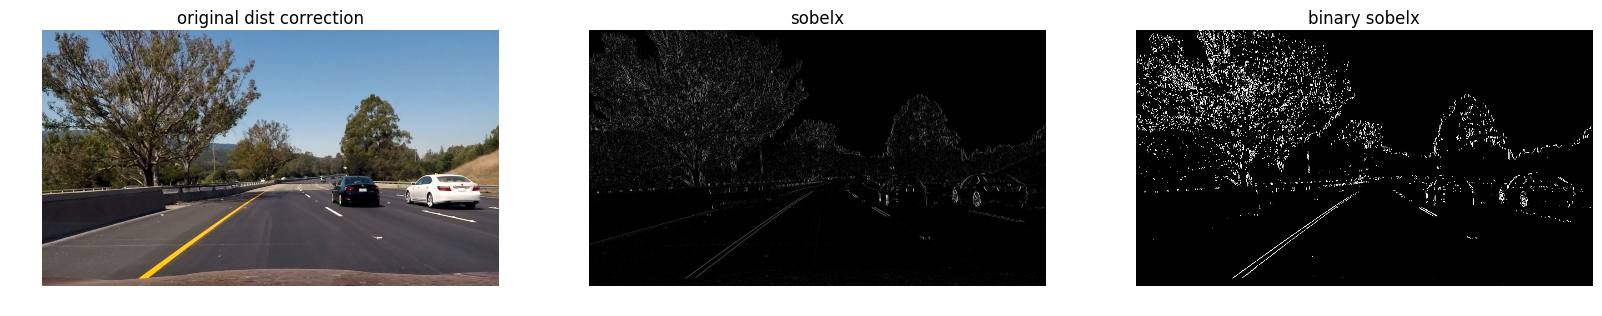

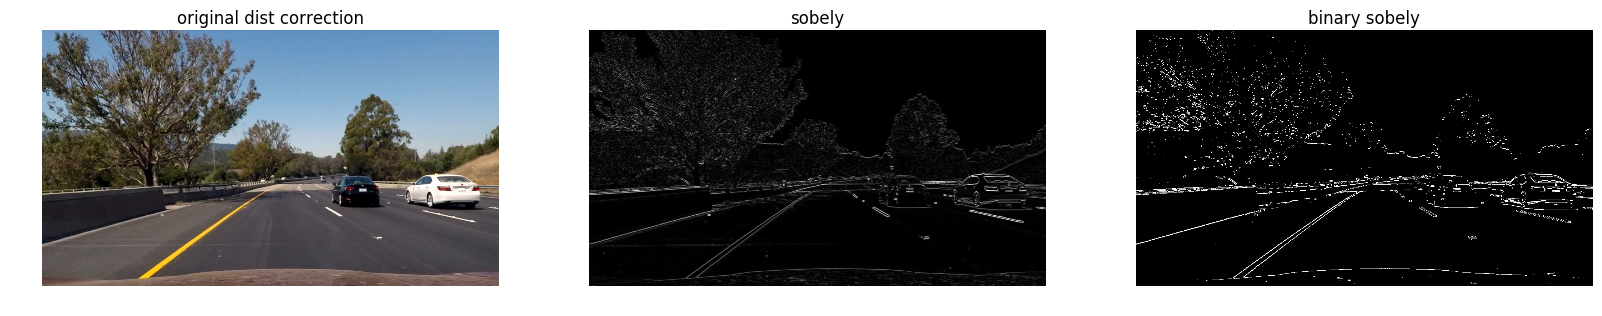

In [8]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient,sobel_kernel, thresh):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output,scaled_sobel
#Testing threshold for sobelx
i = 7
image = dist_correction(test_images[i])
#image,_,_ = warp(image)
fig_sobelx = plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('original dist correction')

bin_image,sobel_image = abs_sobel_thresh(image,'x', 3, (40,100))
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(sobel_image,cmap='gray')
plt.title('sobelx')

plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(bin_image,cmap='gray')
plt.title('binary sobelx')

#Testing threshold for sobely
#i = 2
image = dist_correction(test_images[i])
#image,_,_ = warp(image)
fig_sobely = plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('original dist correction')

bin_image,sobel_image = abs_sobel_thresh(image,'y', 3, (60,150))
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(sobel_image,cmap='gray')
plt.title('sobely')

plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(bin_image,cmap='gray')
plt.title('binary sobely')


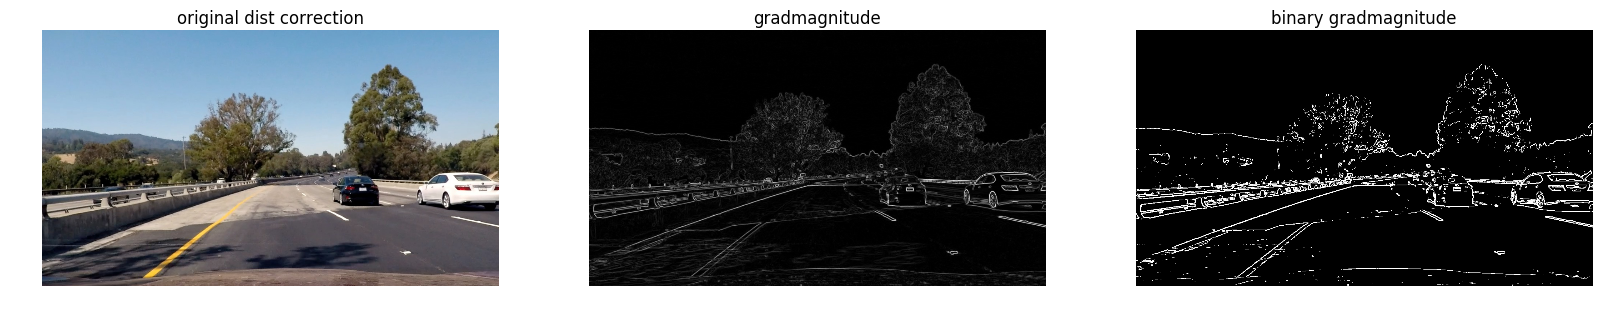

In [9]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_threshold(img, sobel_kernel, mag_thresh):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output,gradmag
#Testing threshold for sobel magnitude
i = 5
image = dist_correction(test_images[i])
#image,_,_ = warp(image)
fig_sobelmag = plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('original dist correction')

bin_mag_image,mag_image = mag_threshold(image, 3, (50,200))
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(mag_image,cmap='gray')
plt.title('gradmagnitude')

plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(bin_mag_image,cmap='gray')
plt.title('binary gradmagnitude')

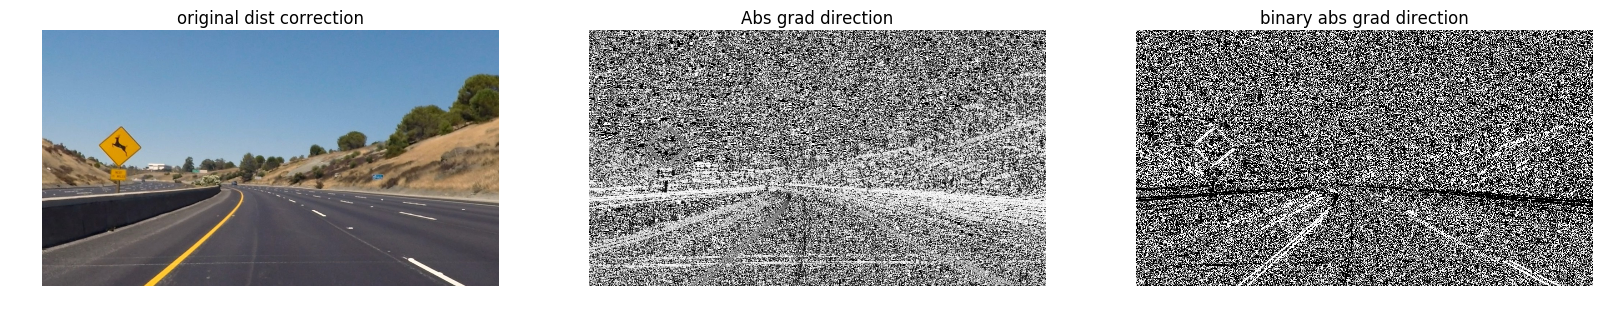

In [10]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel, thresh):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output, absgraddir

#Testing threshold for sobel direction
i = 3
image = dist_correction(test_images[i])
fig_sobeldirection = plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('original dist correction')

bin_dir_image,dir_image = dir_threshold(image, 3, (0.7,1.3))
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(dir_image,cmap='gray')
plt.title('Abs grad direction')

plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(bin_dir_image,cmap='gray')
plt.title('binary abs grad direction')

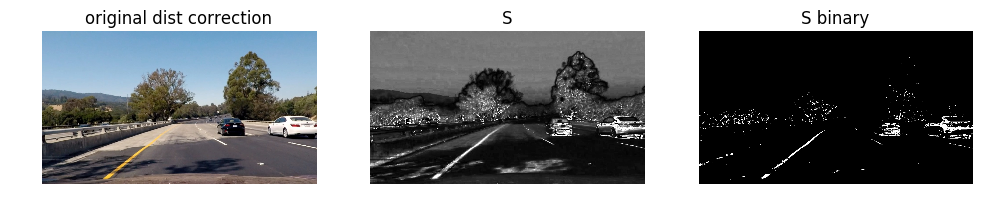

In [11]:
def color_threshold(img,thresh):
    #img,_,_ = warp(img)
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    col_binary_output = np.zeros_like(S)
    col_binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1 
    
    return col_binary_output,S
#check which threshold values work for color thresholding using HLS
fig_color = plt.figure(figsize=(12,14))
i = 5
image = dist_correction(test_images[i])
#Plot original on the left
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('original dist correction')
col_binary_output,S = color_threshold(image,(180,255))
#plot color thresholded image on the right
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(S,cmap='gray')
plt.title('S')
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(col_binary_output,cmap='gray')
plt.title('S binary')
    

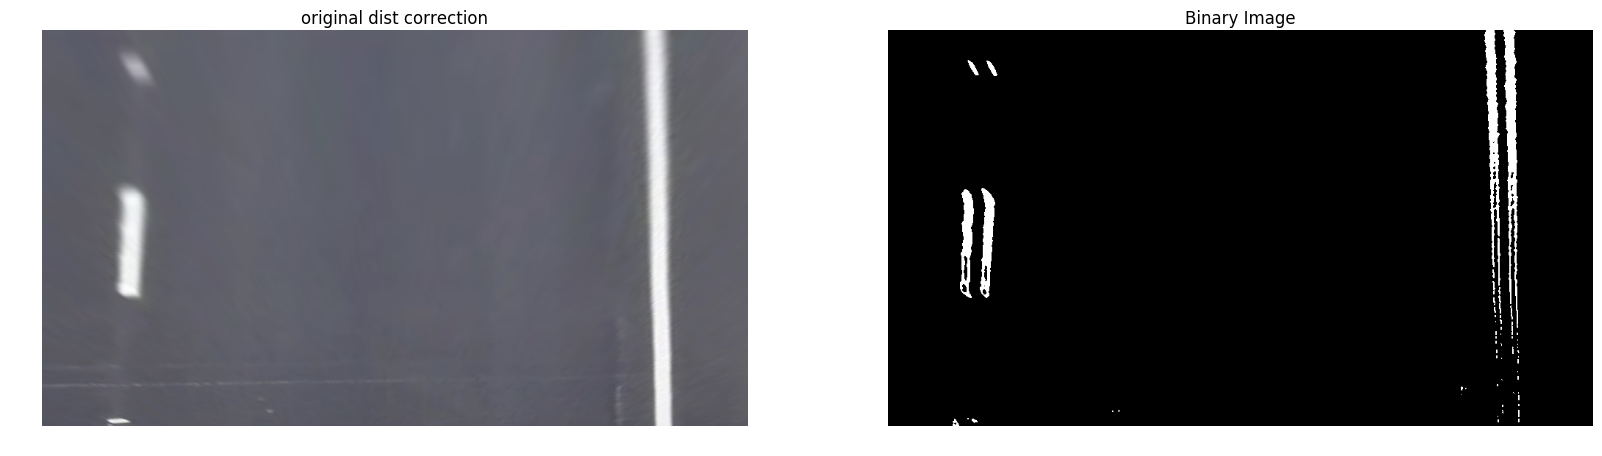

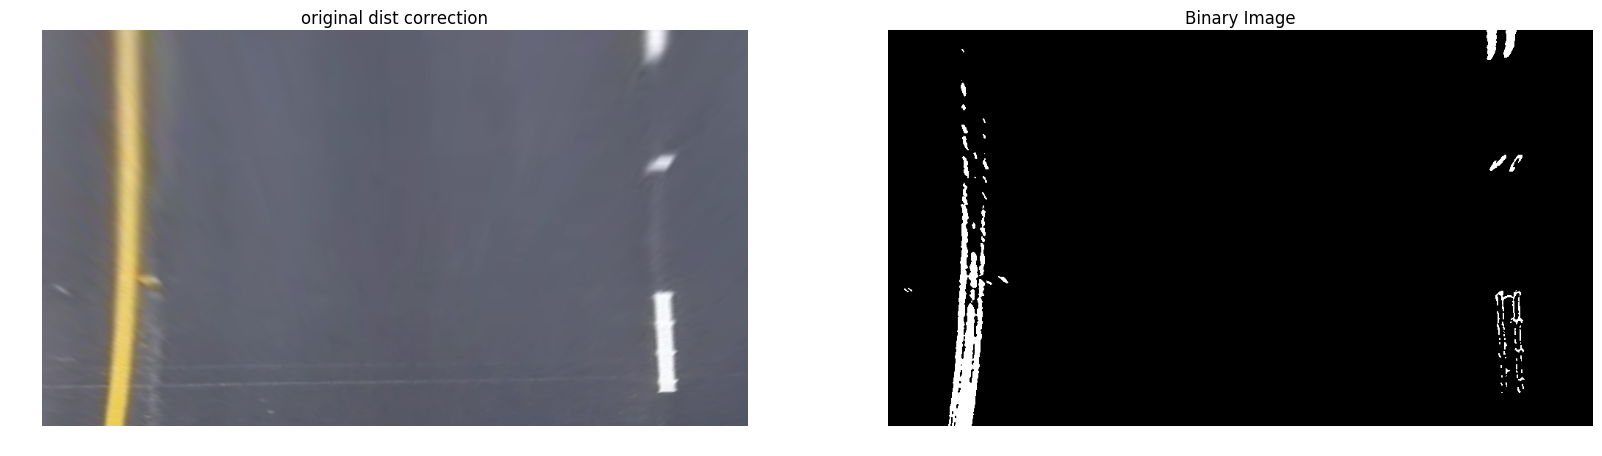

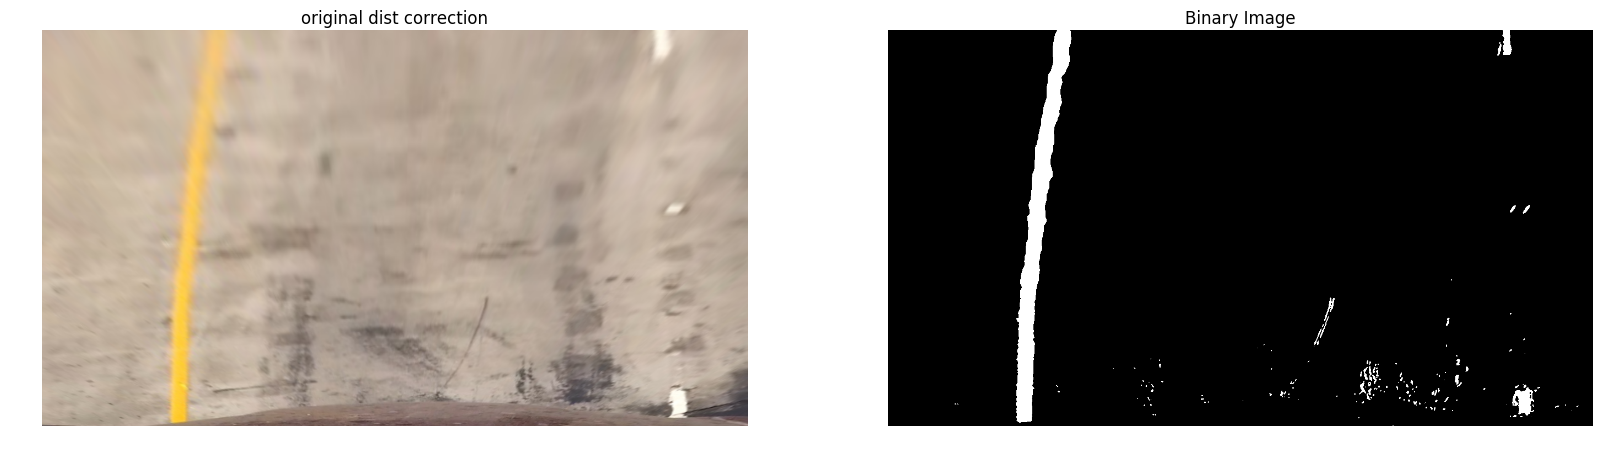

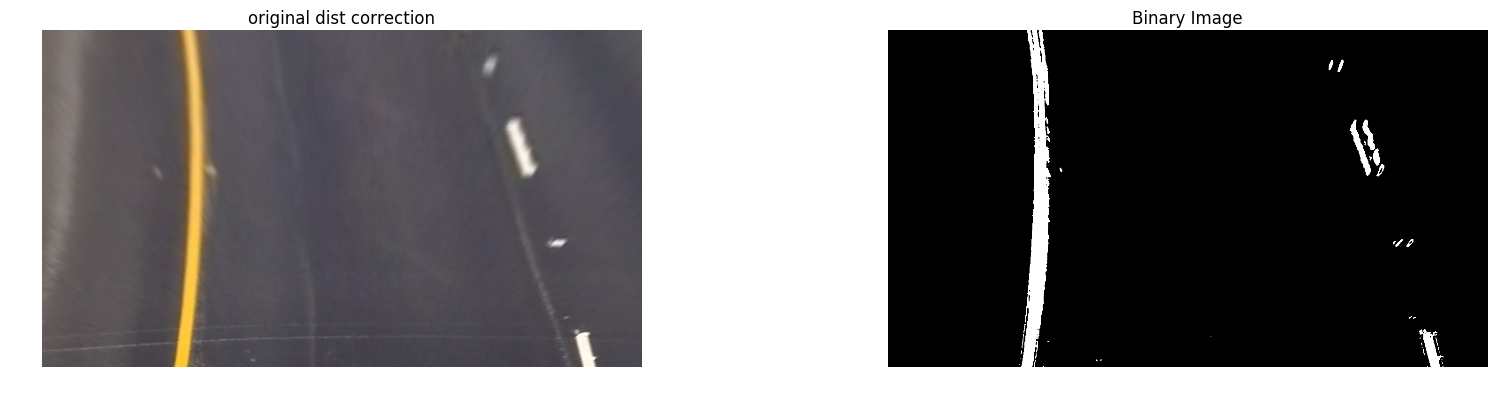

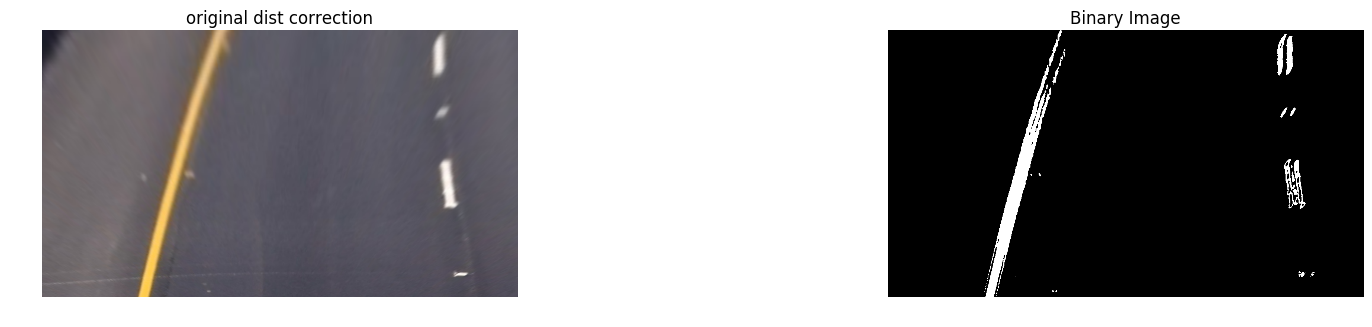

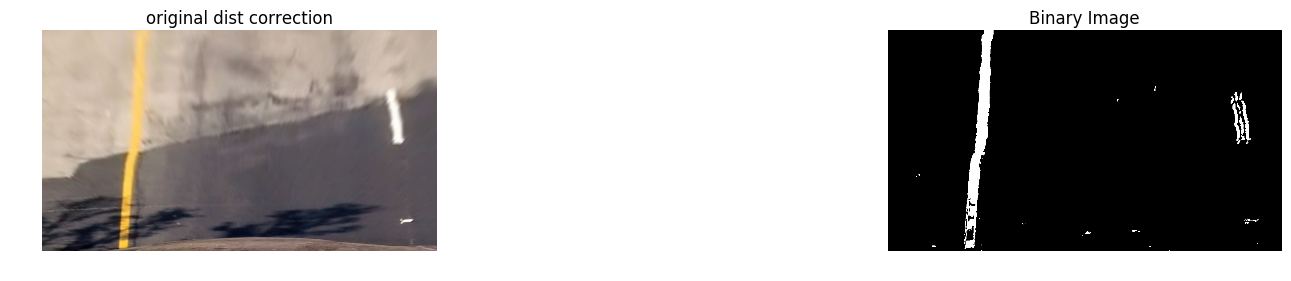

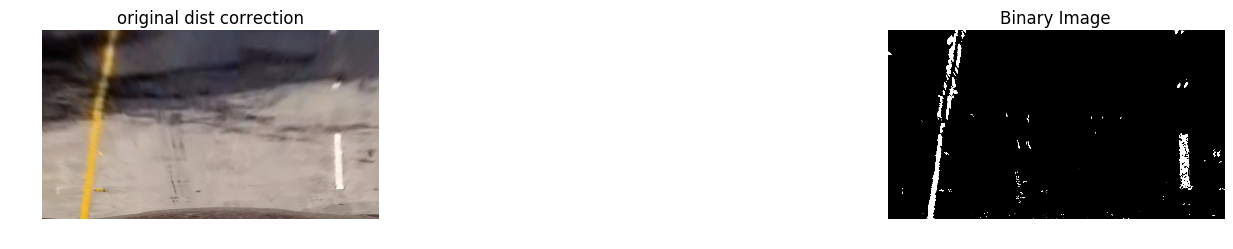

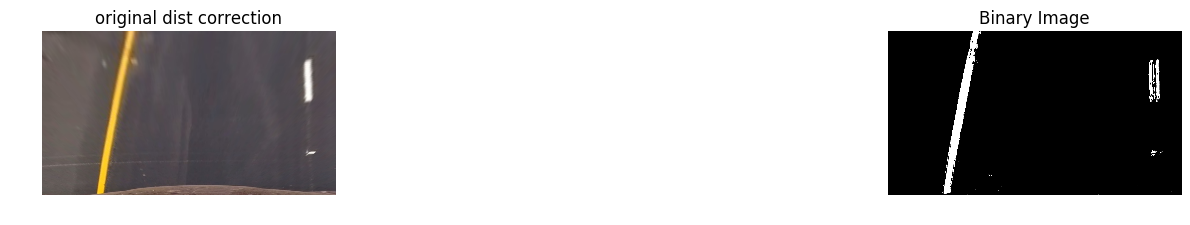

In [63]:
#Use color transforms, gradients, etc., to create a thresholded binary image
def create_binary(img, thresh_x, thresh_y, mag_thresh, dir_thresh, col_thresh, ksize):
    '''Where the magic happens'''

    gradx,_ = abs_sobel_thresh(img,'x', 3, thresh_x)
    grady,_ = abs_sobel_thresh(img,'y', 3, thresh_y)
    mag_binary,_ = mag_threshold(img, ksize,(mag_thresh[0],mag_thresh[1]))
    dir_binary,_ = dir_threshold(img, ksize, (dir_thresh[0],dir_thresh[1])) #(0, np.pi/2)
    col_binary,S = color_threshold(img,col_thresh)

    combined = np.zeros_like(col_binary)
    #combined[((gradx == 1) | (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (col_binary == 1)] = 1
    combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1)) | (col_binary == 1)] = 1
    combined = gaussian_blur(combined, kernel=5)
    return combined

#Testing create binary function
ksize = 3
thresh_x = (40,100)
thresh_y = (60,150)
mag_thresh = (50,200)
dir_thresh = (0.7,1.3)
col_thresh = (180,255)

#fig = plt.figure(figsize=(20,20))
for i in range(len(test_images)):
    plt.figure(figsize=(20,20))
    image = dist_correction(test_images[i])
    image = dist_correction(image)
    image,_,_ = warp(image)
    

    plt.subplot(i+1,2,1)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('original dist correction')

    image_bin = create_binary(image, thresh_x, thresh_y, mag_thresh, dir_thresh,col_thresh, ksize)
    plt.subplot(i+1,2,2)
    plt.axis('off')
    plt.imshow(image_bin,cmap='gray')
    plt.title('Binary Image')

error: ..\..\..\modules\imgproc\src\color.cpp:7935: error: (-215) depth == CV_8U || depth == CV_16U || depth == CV_32F in function cv::cvtColor


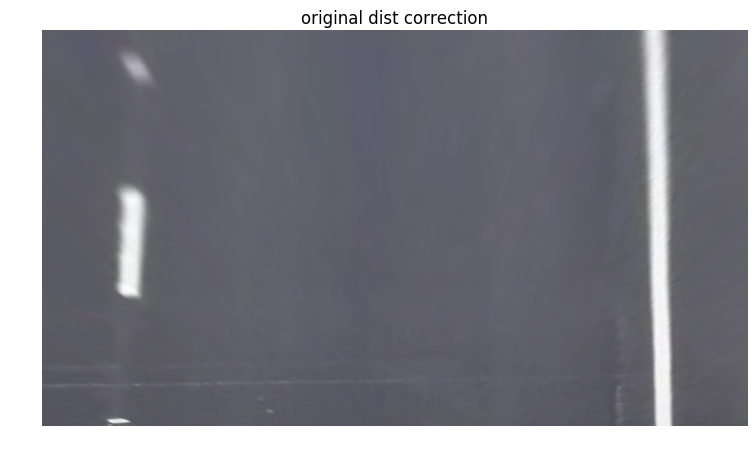

In [64]:
def thresholding_pipeline1(img, kernels= 5, s_thresh=(50,225), l_thresh=(50,225)):
    """
	 Implement thresholding pipeline to detect lanes using gradient
	:param img: Image
    :param kernel: kernel size (odd number)
    :param s_thresh: low/high threshold value for `saturation` channel in HSV color space
    :param l_thresh: low/high threshold value for `light` channel in HSL color space
	:return:
	   thresholded image
	"""
    img = np.copy(img)

    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    ####################
    # Sobel xy - channel l
    sobx = abs_sobel_thresh(l_channel,'x',kernels,s_thresh)
    soby = abs_sobel_thresh(l_channel,'y',kernels,s_thresh)
    l_sobelxy = np.copy(cv2.bitwise_or(sobx,soby))

    ####################
    # Sobel xy - channel s
    sobx = abs_sobel_thresh(s_channel,'x',kernels,s_thresh)
    soby = abs_sobel_thresh(s_channel,'y',kernels,s_thresh)
    s_sobelxy = np.copy(cv2.bitwise_or(sobx,soby))

    ####################
    # Threshold color channel
    image = cv2.bitwise_or(l_sobelxy,s_sobelxy)
    image = gaussian_blur(image,kernels)
    return image

for i in range(len(test_images)):
    plt.figure(figsize=(20,20))
    image = dist_correction(test_images[i])
    image = dist_correction(image)
    image,_,_ = warp(image)
    

    plt.subplot(i+1,2,1)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('original dist correction')

    image_bin = thresholding_pipeline1(image, kernels= 5, s_thresh=(50,225), l_thresh=(50,225))
    plt.subplot(i+1,2,2)
    plt.axis('off')
    plt.imshow(image_bin,cmap='gray')
    plt.title('Binary Image')

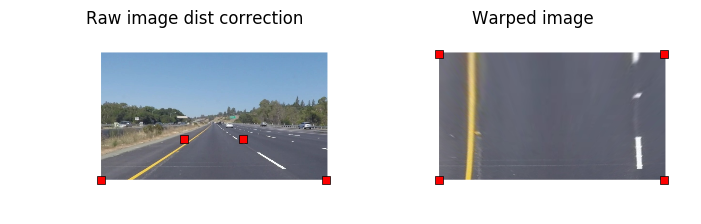

In [26]:
#Apply a perspective transform to rectify binary image ("birds-eye view")
def warp(img):
    img_size = (img.shape[1],img.shape[0])
    image_shape = img.shape
    
    src = np.float32([[image_shape[1]/2-0.26*image_shape[1]/2,1.35*image_shape[0]/2], #Top left
                  [image_shape[1]/2+0.26*image_shape[1]/2,1.35*image_shape[0]/2],#Top right
                  [0,image_shape[0]], #Bottom left
                  [image_shape[1],image_shape[0]]]) #Bottom right
    dst = np.float32([[0,0], #Top left
                  [image_shape[1],0], #Top right
                  [0,image_shape[0]], #Bottom left
                  [image_shape[1],image_shape[0]]]) #Bottom right

    #4 source points creating a plane in the source image
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, src, dst

#Testing Warp function using src and dst points

#Figure out image perspective points
fig_warp = plt.figure(figsize=(8,13))
#Plot original image with points
j=1
image_shape = test_images[j].shape

image = dist_correction(test_images[j])
plt.subplot(4,2,1)
plt.axis('off')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

warped_image,src,dst = warp(image)
for i in range(4):
    plt.plot(src[i][0],src[i][1],'rs')
plt.title('Raw image dist correction')


plt.subplot(4,2,2)
plt.axis('off')
plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
for i in range(4):
    plt.plot(dst[i][0],dst[i][1],'rs')
plt.title('Warped image')

C:\Users\Carlos\Anaconda3\envs\python3\lib\site-packages\ipykernel\__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Carlos\Anaconda3\envs\python3\lib\site-packages\ipykernel\__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


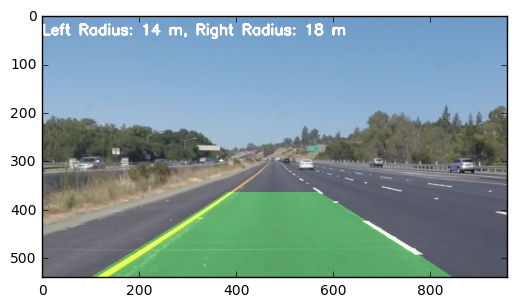

In [35]:
def curvature(image,lefty,leftx, righty,rightx):   
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval_left = np.max(lefty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval_left*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    y_eval_right = np.max(righty)
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval_right*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    cv2.putText(image,"Left Radius: %d m, Right Radius: %d m"%(left_curverad,right_curverad),(0,40),
                cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),3)
    #print(left_curverad, 'm', right_curverad, 'm')
    return image,left_curverad, right_curverad
undist = dist_correction(test_images[1])
image = pipeline(undist)
image,left_fitx,lefty,leftx, right_fitx,righty, rightx= detect_lanes(image)
image = unwarp(undist,left_fitx,lefty,right_fitx,righty)
image,left_curverad,right_curverad = curvature(image,left_fitx,lefty, right_fitx, righty)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#print([left_curverad,right_curverad])

C:\Users\Carlos\Anaconda3\envs\python3\lib\site-packages\ipykernel\__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Carlos\Anaconda3\envs\python3\lib\site-packages\ipykernel\__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


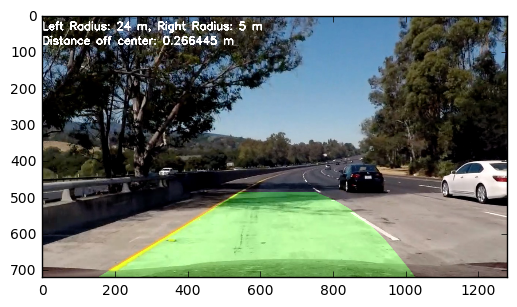

In [34]:
def car_center_line(image,leftx,lefty,rightx,righty):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    rightx_int = right_fit[0]*image.shape[0]**2 + right_fit[1]*image.shape[0] + right_fit[2]
    leftx_int = left_fit[0]*image.shape[0]**2 + left_fit[1]*image.shape[0] + left_fit[2]
    
    # Calculate center position by using the x intercept of each left and right line
    center = abs(image.shape[1]/2 - ((rightx_int+leftx_int)/2))*xm_per_pix
    
    cv2.putText(image,"Distance off center: %f m"%(center),(0,80),
                cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),3)
    
    return image

undist = dist_correction(test_images[6])
image = pipeline(undist)
image,left_fitx,lefty,leftx, right_fitx,righty, rightx= detect_lanes(image)
image = unwarp(undist,left_fitx,lefty,right_fitx,righty)
image,left_curverad,right_curverad = curvature(image,left_fitx,lefty, right_fitx, righty)
image = car_center_line(image,leftx,lefty,rightx,righty)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

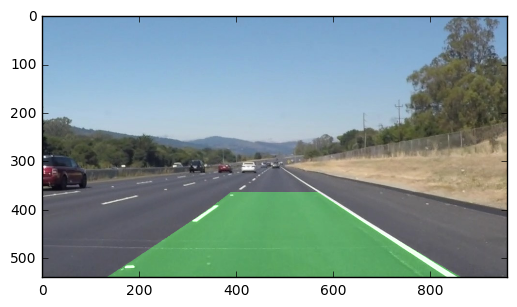

In [77]:
#Warp the detected lane boundaries back onto the original image and superimpose the green shaded area (from Udacity lesson point 35)
def unwarp(undist,left_fitx,lefty,right_fitx,righty):
    image_shape = undist.shape
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(undist).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    src = np.float32([[image_shape[1]/2-0.26*image_shape[1]/2,1.35*image_shape[0]/2], #Top left
                  [image_shape[1]/2+0.26*image_shape[1]/2,1.35*image_shape[0]/2],#Top right
                  [0,image_shape[0]], #Bottom left
                  [image_shape[1],image_shape[0]]]) #Bottom right
    dst = np.float32([[0,0], #Top left
                  [image_shape[1],0], #Top right
                  [0,image_shape[0]], #Bottom left
                  [image_shape[1],image_shape[0]]]) #Bottom right
    #4 source points creating a plane in the source image
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image_shape[1], image_shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result
undist = test_images[0]
image = pipeline(undist)
image,left_fitx,lefty,leftx,right_fitx,righty,rightx= detect_lanes(image)
image = unwarp(undist,left_fitx,lefty,right_fitx,righty)

plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

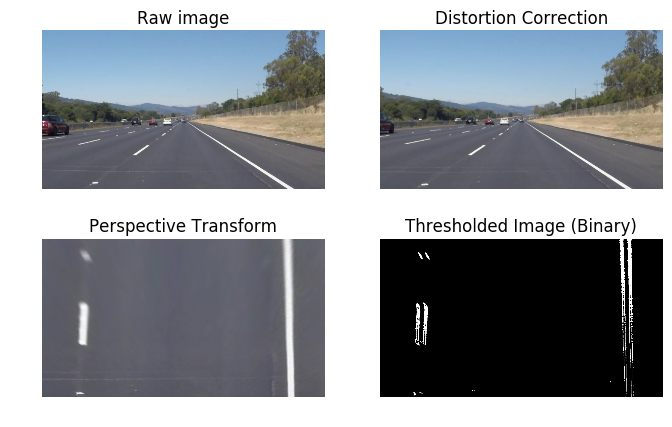

In [28]:
#Pipeline
def pipeline(image):
    ksize = 3
    thresh_x = (40,100)
    thresh_y = (60,150)
    mag_thresh = (50,200)
    dir_thresh = (0.7,1.3)
    col_thresh = (180,255)
    image = dist_correction(image)
    image,_,_ = warp(image)
    image = create_binary(image, thresh_x, thresh_y, mag_thresh, dir_thresh, col_thresh,ksize)
    return image

#Testing pipeline
ksize = 3
thresh_x = (40,100)
thresh_y = (60,150)
mag_thresh = (50,200)
dir_thresh = (0.7,1.3)
col_thresh = (120,255)
#for image in test_images[1]:
fig2 = plt.figure(figsize=(8,13))

image = test_images[0]
plt.subplot(5,2,1)
plt.axis('off')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Raw image')

image = dist_correction(image)
plt.subplot(5,2,2)
plt.axis('off')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Distortion Correction')

image,_,_ = warp(image)
plt.subplot(5,2,3)
plt.axis('off')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Perspective Transform')

image_bin = create_binary(image, thresh_x, thresh_y, mag_thresh, dir_thresh, col_thresh,ksize)
plt.subplot(5,2,4)
plt.axis('off')
plt.imshow(image_bin,cmap='gray')
plt.title('Thresholded Image (Binary)')


C:\Users\Carlos\Anaconda3\envs\python3\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Carlos\Anaconda3\envs\python3\lib\site-packages\ipykernel\__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


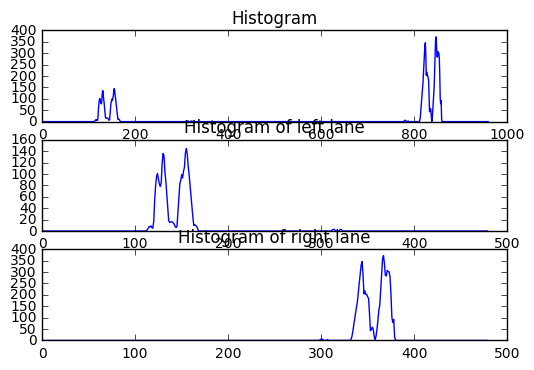

In [36]:
#Differentiate lines left and right
#Calculate histogram
image = pipeline(test_images[0])
histogram = np.sum(image,axis=0)
plt.subplot(3,1,1)
plt.plot(histogram)
plt.title('Histogram')

left_histogram = np.sum(image[:,0:image.shape[1]/2],axis=0)
plt.subplot(3,1,2)
plt.plot(left_histogram)
plt.title('Histogram of left lane')

right_histogram = np.sum(image[:,image.shape[1]/2:image.shape[1]],axis=0)
plt.subplot(3,1,3)
plt.plot(right_histogram)
plt.title('Histogram of right lane')

left_peak_x = np.max(0)
right_peak_x = 0

#plt.show()

C:\Users\Carlos\Anaconda3\envs\python3\lib\site-packages\ipykernel\__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Carlos\Anaconda3\envs\python3\lib\site-packages\ipykernel\__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Carlos\Anaconda3\envs\python3\lib\site-packages\ipykernel\__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


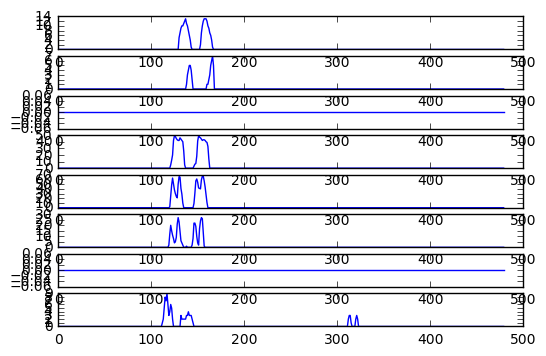

In [37]:
y_vals = []
x_left = []
x_right = []
left_peaks = []
right_peaks = []
image = pipeline(test_images[0])
# for i,item in enumerate(test_images):
#     plt.show(item)
#     plt.title('Pic'+i)

x, y = np.nonzero(np.transpose(image))

for i in range(8):
    #find peaks of 1/10 of histogram, save in array
    y1 = image.shape[0]-image.shape[0]*i/8
    y2 = image.shape[0]-image.shape[0]*(i+1)/8
    #histogram = np.mean(image[y2:y1,:],axis=0)
    histogram = np.sum(image[y2:y1,:],axis=0)
    left_histogram = histogram[:image.shape[1]/2]
    right_histogram = histogram[image.shape[1]/2:image.shape[1]]
  
    #plot histogram
    plt.subplot(8,1,8-i)
    plt.plot(left_histogram)
        
    

In [79]:
 def detect_lanes(combined_binary):
    
    rightx = []
    righty = []
    leftx = []
    lefty = []
    x, y = np.nonzero(np.transpose(combined_binary))
    
    increments = 90
    offset = 20
    i = combined_binary.shape[0]
    j = combined_binary.shape[0] - increments
    
    while j >= 0:
        histogram = np.sum(combined_binary[j:i,:], axis=0)
        left_peak = np.argmax(histogram[:combined_binary.shape[1]/2])
        x_idx = np.where((((left_peak - offset) < x)&(x < (left_peak + offset))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            leftx.extend(x_window.tolist())
            lefty.extend(y_window.tolist())

        right_peak = np.argmax(histogram[combined_binary.shape[1]/2:]) + combined_binary.shape[1]/2
        x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            rightx.extend(x_window.tolist())
            righty.extend(y_window.tolist())
            
        i -= increments
        j -= increments

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    rightx_int = right_fit[0]*combined_binary.shape[0]**2 + right_fit[1]*combined_binary.shape[0] + right_fit[2]
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty, image.shape[0])
    rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    righty = np.append(righty, 0)
    leftx_int = left_fit[0]*combined_binary.shape[0]**2 + left_fit[1]*combined_binary.shape[0] + left_fit[2]
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, image.shape[0])
    leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    lefty = np.append(lefty, 0)
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    righty = righty[rsort]
    rightx = rightx[rsort]
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])
    pts = np.hstack((pts_left, pts_right))
    warped,_,_ = warp(image)
    cv2.polylines(warped,np.int_([pts]),True,(0,255,0))
         
    return warped,left_fitx,lefty,leftx,right_fitx,righty,rightx

#Test detect_lanes, and use unwarp to unwarp the image    
# image = test_images[0]
# combined_binary = pipeline(image)
# left_fitx,lefty,right_fitx,righty = detect_lanes(image)
# unwarped_image = unwarp(combined_binary,image,left_fitx,lefty,right_fitx,righty)
# plt.imshow(cv2.cvtColor(unwarped_image, cv2.COLOR_BGR2RGB))

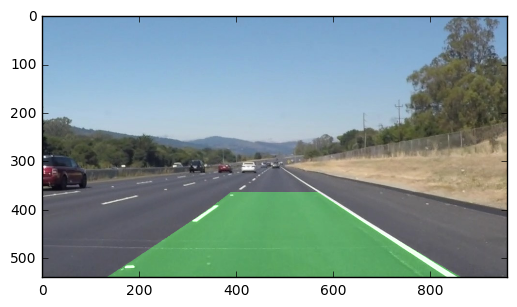

In [80]:
_,left_fitx,lefty,leftx,right_fitx,righty,rightx = detect_lanes(pipeline(test_images[0]))
image = unwarp(test_images[0],left_fitx,lefty,right_fitx,righty)

plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))


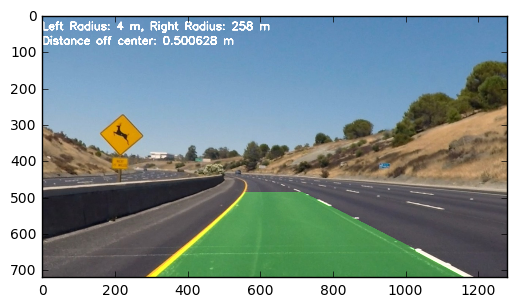

In [83]:
###Final pipeline
def final_pipeline(image):
    ksize = 3
    thresh_x = (40,100)
    thresh_y = (60,150)
    mag_thresh = (50,200)
    dir_thresh = (0.7,1.3)
    col_thresh = (120,255)
    undist = image
    image = dist_correction(undist)
    image,_,_ = warp(image)
    image = create_binary(image, thresh_x, thresh_y, mag_thresh, dir_thresh, col_thresh,ksize)
    warped_image_with_lines,left_fitx,lefty,leftx,right_fitx,righty,rightx= detect_lanes(image)
    image = unwarp(dist_correction(undist),left_fitx,lefty,right_fitx,righty)
    image,left_curverad, right_curverad = curvature(image,left_fitx,lefty, right_fitx, righty)
    image = car_center_line(image,leftx,lefty,rightx,righty)
    return image

plt.imshow(cv2.cvtColor(final_pipeline(test_images[3]),cv2.COLOR_BGR2RGB))

In [84]:
###VIDEO
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [85]:
video_output = 'CarND-Advanced-Lane-Lines-master/project_video_output.mp4'
clip1 = VideoFileClip("CarND-Advanced-Lane-Lines-master/project_video.mp4")
video_clip = clip1.fl_image(final_pipeline) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video CarND-Advanced-Lane-Lines-master/project_video_output.mp4
[MoviePy] Writing video CarND-Advanced-Lane-Lines-master/project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [14:52<00:01,  1.46s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: CarND-Advanced-Lane-Lines-master/project_video_output.mp4 

Wall time: 14min 58s


In [879]:
###Play the video inline
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))